In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from collections import Counter
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
# Specify the path to the CSV file
file_path_train = "data/train.csv"
file_path_test = "data/test.csv"


# Read the CSV file into a DataFrame
df = pd.read_csv(file_path_train, delimiter=",", parse_dates=['host_since', 'first_review', 'last_review'])
df_test = pd.read_csv(file_path_test, delimiter=",", parse_dates=['host_since', 'first_review', 'last_review'])

# Drop the original price column and separate features and target
y = df['price']
X = df.drop(columns=['price'])
ID_test = df_test["id"]
X_test = df_test.drop(columns=['id'])


In [2]:
from transformers import pipeline

classifier = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment",device=0)
#EX
review = "This house is terrible, do not go!"
result = classifier(review)
print(result)


[{'label': '1 star', 'score': 0.9736103415489197}]


In [3]:
# def process_batch_input(X_data, classifier):
#     # Processing 'name' column
#     batch_input = X_data["name"].tolist()  # Convert to list for batch processing
#     results = classifier(batch_input)  # Perform batch classification
#     X_data['name_pred'] = [res['label'] for res in results]  # Assuming each result is a list of predictions
#     X_data['name_score'] = [res['score'] for res in results]  # Adjust if classifier returns more

#     # Processing 'description' column
#     X_data['description'] = X_data['description'].astype(str)  # Ensure all are strings
#     batch_input = X_data["description"].tolist()  # Convert to list for batch processing
#     results = classifier(batch_input)  # Perform batch classification
#     X_data['description_pred'] = [res['label'] for res in results]  # Assuming each result is a list of predictions
#     X_data['description_score'] = [res['score'] for res in results]  # Adjust if classifier returns more

#     return X_data

# # Usage
# X = process_batch_input(X, classifier)
# X_test = process_batch_input(X_test, classifier)
# # Save predictions and scores for X
# X[['name_pred','name_score','description_pred', 'description_score']].to_csv('data/my_data/X_description_predictions.csv', index=False)
# # Save predictions and scores for X_test
# X_test[['name_pred','name_score','description_pred', 'description_score']].to_csv('data/my_data/X_test_description_predictions.csv', index=False)

In [4]:
# Helper function to extract star level and create new columns
def add_star_scores(df, col_pred, col_score, prefix):
    for star in range(1, 6):  # Loop over star levels 1 to 5
        star_label = f"{star} stars"
        df[f"{prefix}_{star}"] = df.apply(
            lambda row: row[col_score] if row[col_pred] == star_label else 0, axis=1
        )
    return df
# Read the prediction files
X_preds = pd.read_csv('data/my_data/X_description_predictions.csv')
X_test_preds = pd.read_csv('data/my_data/X_test_description_predictions.csv')

# Transform data for name and description
X_preds = add_star_scores(X_preds, "name_pred", "name_score", "name")
X_preds = add_star_scores(X_preds, "description_pred", "description_score", "description")
# Drop original prediction columns
X_preds = X_preds.drop(columns=["name_pred", "name_score", "description_pred", "description_score"])

# Transform data for name and description
X_test_preds = add_star_scores(X_test_preds, "name_pred", "name_score", "name")
X_test_preds = add_star_scores(X_test_preds, "description_pred", "description_score", "description")
# Drop original prediction columns
X_test_preds = X_test_preds.drop(columns=["name_pred", "name_score", "description_pred", "description_score"])

# Concatenate the predictions with X and X_test on axis 1 (column-wise)
X = pd.concat([X, X_preds], axis=1)
X_test = pd.concat([X_test, X_test_preds], axis=1)

In [5]:
# from datasets import Dataset
# import math
# from collections import defaultdict
# # Define candidate labels

# # Function to classify multiple reviews for a single property
# def classify_property_reviews(reviews_text, separator="---------------------------------"):
#     # Split concatenated reviews
#     reviews = ""
#     if pd.isna(reviews_text):        
#         #print(reviews_text)
#         reviews = ["netrual"]
#     else: 
#         #print(reviews_text)
#         reviews = reviews_text.split(separator)    
#     # Classify reviews in batch using the pipeline
#         reviews = reviews_text.split(separator)
#         reviews = [review.strip() for review in reviews if review.strip()]  # Make sure each review is a clean, non-empty string
    
#     # Classify reviews in batch using the pipeline
#     results = []
#     for review in reviews:
#         if ( len(review) >=512):
#             review = review[0:510]
#         result = classifier(review)
#         results.append(result)

#     # Step 1: Aggregate labels and scores
#     aggregated_results = defaultdict(list)

#     # Loop through the results and store the label and score
#     for result in results:
#         for entry in result:
#             label = entry['label']
#             score = entry['score']
#             aggregated_results[label].append(score)

#     # Step 2: Calculate the average score for each label
#     final_results = {
#         label: {'count': len(scores), 'average_score': sum(scores) / len(scores)}
#         for label, scores in aggregated_results.items()
#     }
#     return final_results


# # Convert X_test to Hugging Face Dataset format
# # Assuming X_test is your original pandas DataFrame

# # Apply the classification function to each review in a batch

#     # Apply the classification function to each review
# results = []
# total_reviews = len(X['reviews'])  # Get the total number of reviews

# for i, review in enumerate(X['reviews']):
#     # Perform the classification
#     results.append(classify_property_reviews(review))
    
#     # Print progress every 25 reviews as a percentage of the total
#     if (i + 1) % 25 == 0:
#         progress = (i + 1) / total_reviews * 100
#         print(f"Processed {i + 1} reviews out of {total_reviews} ({progress:.2f}%)")


# df_rows = []
# for entry in results:
#     row = {}
#     for star, values in entry.items():
#         row[f'{star}_count'] = values['count']
#         row[f'{star}_average_score'] = values['average_score']
#     df_rows.append(row)

# # Create a DataFrame from the rows
# df_rev = pd.DataFrame(df_rows)
# # Write the DataFrame to a CSV file
# df_rev.to_csv('data/my_data/classified_reviews_X.csv', index=False)  # index=False to avoid writing row indices
# print("DataFrame written to 'src/main_workspace/Final_Project/data/my_data/classified_reviews.csv'")

In [6]:
# Read the CSV file back into a DataFrame
df_x_test_reviews= pd.read_csv('data/my_data/classified_reviews_X_test.csv')
df_X_reviews= pd.read_csv('data/my_data/classified_reviews_X.csv')

X_clean = X.copy()
X_test_clean = X_test.copy()

X_clean = pd.concat([X_clean, df_X_reviews], axis=1)
X_test_clean = pd.concat([X_test_clean,df_x_test_reviews], axis=1)

In [7]:
# all_amenities = [item for sublist in df['amenities'].to_numpy() for item in sublist]
    
#     # Count occurrences of each amenity
# amenity_counts = Counter(all_amenities)
# len(amenity_counts)

In [8]:
def get_top_amenities(list_of_lists,n=10):
    # Flatten the list of lists
    all_amenities = [item for sublist in list_of_lists for item in sublist]
    
    # Count occurrences of each amenity
    amenity_counts = Counter(all_amenities)
    
    # Get the top 10 most common amenities
    top_n_amenities = amenity_counts.most_common(n)
    
    # Extract just the amenity names
    top_amenity_names = [amenity for amenity,count in top_n_amenities]
    
    # Calculate the total number of amenities for each row
    total_amenities_per_row = [len(sublist) for sublist in list_of_lists]
    
    return top_amenity_names, total_amenities_per_row

# Convert the 'amenities' column from string format to a Python list
X['amenities'] = X['amenities'].str.replace('[', '').str.replace(']', '').str.replace('"', '').str.split(', ')
X_test['amenities'] = X_test['amenities'].str.replace('[', '').str.replace(']', '').str.replace('"', '').str.split(', ')
# Get top 3000 amenities
n = 3000
top_amenities,total_amenities_per_row = get_top_amenities(X['amenities'].to_numpy(),n)
top_amenities_test, total_amenities_per_row_test = get_top_amenities(X_test['amenities'].to_numpy(), n)

# Convert datetime columns for X
datetime_columns = ['host_since', 'first_review', 'last_review']
for col in datetime_columns:
    X[col] = pd.to_datetime(X[col], errors='coerce')
    min_date = X[col].min()
    X[f'{col}_numeric'] = (X[col] - min_date).dt.days
    X[f'{col}_numeric'] = X[f'{col}_numeric'].replace({pd.NaT: np.nan})

# Convert datetime columns for X_test
for col in datetime_columns:
    X_test[col] = pd.to_datetime(X_test[col], errors='coerce')
    min_date = X_test[col].min()
    X_test[f'{col}_numeric'] = (X_test[col] - min_date).dt.days
    X_test[f'{col}_numeric'] = X_test[f'{col}_numeric'].replace({pd.NaT: np.nan})



In [9]:
print(df.index)

RangeIndex(start=0, stop=15696, step=1)


In [10]:
# Print the type and first row value of each column
for col in df.columns:
    print(f"{col} (Type: {df[col].dtype}): {df[col].iloc[0]}")

name (Type: object): Bed-Stuy 2 Bed/2 Bath - Renovated
description (Type: object): Welcome to Bed-Stuy, Brooklyn! Our newly renovated brownstone has an apartment that is colorful and comfortable and entirely yours during your stay. Bed-Stuy is a friendly neighborhood with tree-lined streets and rows upon rows of traditional brownstones. We are close to many restaurants and coffee shops as well as perfectly located for exploring Brooklyn. Relax on the patio or take a quick trip into that other borough (Manhattan). We are a 5 minute walk to the Kingston/Throop C subway.
property_type (Type: object): Entire rental unit
price (Type: int64): 4
neighbourhood_cleansed (Type: object): Bedford-Stuyvesant
neighbourhood_group_cleansed (Type: object): Brooklyn
latitude (Type: float64): 40.68456
longitude (Type: float64): -73.93987
host_since (Type: datetime64[ns]): 2015-05-23 00:00:00
host_response_time (Type: object): within a day
host_response_rate (Type: float64): 100.0
host_acceptance_rate (Ty

In [11]:
# Separate numeric and other columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
other_cols = X.select_dtypes(include=['object']).columns
#X_clean = X.copy()

# Create one-hot encoded columns for the top amenities in a vectorized way
amenities_df = pd.DataFrame(
    {f'has_{amenity.lower().replace(" ", "_")}': X_clean['amenities'].apply(lambda x: int(amenity in x)) 
     for amenity in top_amenities}
)

# Concatenate the new columns with the original DataFrame
X_clean = pd.concat([X_clean, amenities_df], axis=1)
    
X_clean = X_clean.drop(columns=["name","description","reviews","amenities","bathrooms_text",'host_since', 'first_review', 'last_review'])

# make new row for total_amenities
X_clean['total_amenities'] = total_amenities_per_row


#might remove neighbourhood_cleansed as it has a lot
cat_columns = ['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', "host_verifications","host_response_time","room_type"]
X_clean[cat_columns] = X_clean[cat_columns].astype('category')

#fix boolean data
X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna(False).astype(bool)
X_clean['has_availability'] = X_clean['has_availability'].fillna(False).astype(bool)


# Scale only the numeric columns
# scaler = StandardScaler()
# X_clean[numeric_cols] = scaler.fit_transform(X_clean[numeric_cols])

# One-hot encode categorical columns
#X_clean = pd.get_dummies(X_clean, columns=cat_columns, drop_first=True)

# converting a categorical column to integer labels
for col in cat_columns:  # replace with your actual categorical columns
    X_clean[col] = LabelEncoder().fit_transform(X_clean[col])
categorical_features = [X_clean.columns.get_loc(col) for col in cat_columns]

# Function to clean column names
def clean_column_name(col_name):
    return col_name.replace('[', '').replace(']', '').replace('<', '')
# Apply the cleaning function to all column names
X_clean.columns = X_clean.columns.map(clean_column_name)


# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.2, random_state=42)

/tmp/ipykernel_50575/1146424666.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna(False).astype(bool)
/tmp/ipykernel_50575/1146424666.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['has_availability'] = X_clean['has_availability'].fillna(False).astype(bool)


In [12]:
# Separate numeric and other columns for X_test
numeric_cols_test = X_test.select_dtypes(include=['float64', 'int64']).columns
other_cols_test = X_test.select_dtypes(include=['object']).columns
#X_test_clean = X_test.copy()

# Create one-hot encoded columns for the top amenities in a vectorized way for X_test
amenities_df_test = pd.DataFrame(
    {f'has_{amenity.lower().replace(" ", "_")}': X_test_clean['amenities'].apply(lambda x: int(amenity in x)) 
     for amenity in top_amenities}
)

# Concatenate the new columns with the original DataFrame for X_test
X_test_clean = pd.concat([X_test_clean, amenities_df_test], axis=1)

X_test_clean = X_test_clean.drop(columns=["name","description","reviews","amenities","bathrooms_text",'host_since', 'first_review', 'last_review'])

# Make new row for total_amenities for X_test
X_test_clean['total_amenities'] = total_amenities_per_row_test

# might remove neighbourhood_cleansed as it has a lot of categories
cat_columns_test = ['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', "host_verifications","host_response_time","room_type"]
X_test_clean[cat_columns_test] = X_test_clean[cat_columns_test].astype('category')

# Fix boolean data for X_test
X_test_clean['host_is_superhost'] = X_test_clean['host_is_superhost'].fillna(False).astype(bool)
X_test_clean['has_availability'] = X_test_clean['has_availability'].fillna(False).astype(bool)

# One-hot encode categorical columns if needed
# X_test_clean = pd.get_dummies(X_test_clean, columns=cat_columns_test, drop_first=True)

# Converting a categorical column to integer labels for X_test
for col in cat_columns_test:
    X_test_clean[col] = LabelEncoder().fit_transform(X_test_clean[col])
categorical_features_test = [X_test_clean.columns.get_loc(col) for col in cat_columns_test]

# Function to clean column names for X_test
def clean_column_name(col_name):
    return col_name.replace('[', '').replace(']', '').replace('<', '')

# Apply the cleaning function to all column names in X_test
X_test_clean.columns = X_test_clean.columns.map(clean_column_name)


/tmp/ipykernel_50575/3842504247.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_clean['host_is_superhost'] = X_test_clean['host_is_superhost'].fillna(False).astype(bool)
/tmp/ipykernel_50575/3842504247.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_clean['has_availability'] = X_test_clean['has_availability'].fillna(False).astype(bool)


In [13]:
# len(X_clean.columns)
# for col in X_clean.columns:
#     print(f"{col} (Type: {X_clean[col].dtype}): {X_clean[col].iloc[0]}")

In [14]:
unique_categories = df['host_identity_verified'].unique()
# Verify the result
print(len(unique_categories))
print(unique_categories)

2
[ True False]


In [15]:
# object_columns = X_clean.select_dtypes(include=['object']).columns
# print("Columns of type 'object' in X_clean:")
# for col in object_columns:
#     print(col)
# object_columns = X_clean.select_dtypes(include=['datetime']).columns
# print("Columns of type 'time' in X_clean:")
# for col in object_columns:
#     print(col)


0.8070154182853748

In [16]:

# # Initialize and train HistGradientBoostingClassifier or HistGradientBoostingRegressor
# model = HistGradientBoostingClassifier(categorical_features=categorical_features, random_state=42)
# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01],
#     'max_iter': [200],
#     'max_depth': [9],
#     'l2_regularization': [0.1, 0.2],
#     'min_samples_leaf': [3]
# }
# # Set up the grid search
# grid_search = GridSearchCV(model, param_grid, cv=5,verbose=3, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters
# print(grid_search.best_params_)
# # Use the best model from the grid search to make predictions
# best_model = grid_search.best_estimator_
# #y_pred = np.round(best_model.predict(X_val))
# y_pred = (best_model.predict(X_val))

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)


# # Calculate RMSE by treating the quantile labels as numeric values
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# print("Accuracy on validation set:", accuracy)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


0.9132778509966281

In [17]:

# # Initialize and train HistGradientBoostingClassifier
# # Define the parameter grid
# params = {'l2_regularization': 0.2,'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'min_samples_leaf': 5}

# model = HistGradientBoostingClassifier(categorical_features=categorical_features, random_state=42, **params)

# # Fit the model
# model.fit(X_train, y_train)

# #y_pred = np.round(best_model.predict(X_val))
# y_pred = (model.predict(X_val))

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)


# # Calculate RMSE by treating the quantile labels as numeric values
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# print("Accuracy on validation set:", accuracy)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


0.75354787167402880.

0.7524905568952746

In [ ]:
Root Mean Squared Error on validation set: 0.7411902976461854


In [41]:

# Define the model with custom parameters
# params = {
#     'learning_rate': 0.01,
#     'max_depth': 9,
#     'min_child_weight': 3,
#     'reg_lambda': 1.0,
#     'reg_alpha': 0.1,
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'objective': 'reg:squarederror',  # For regression
#     'eval_metric': 'rmse',            # RMSE as evaluation metric
# }


#Best_Parameters =  {'learning_rate': 0.020534279384947673, 'max_depth': 9, 'n_estimators': 1800, 'subsample': 0.6817057463318822, 'colsample_bytree': 0.7324724625794548, 'reg_lambda': 0.2145407717059405, 'reg_alpha': 0.7071638502266191, 'min_child_weight': 1,'random_state': 1  }
Best_Parameters =  {'learning_rate': 0.020534279384947673, 'max_depth': 9, 'n_estimators': 1800, 'subsample': 1, 'colsample_bytree': 0.7324724625794548, 'reg_lambda': 0.2145407717059405, 'reg_alpha': 0.7071638502266191, 'min_child_weight': 1,'random_state': 1}

#est_Parameters = {'max_depth': 9, 'n_estimators': 1800, 'learning_rate': 0.08748281247944359, 'subsample': 0.7995986950841062, 'colsample_bytree': 0.7148792079582755, 'reg_lambda': 0.9949385383449679, 'reg_alpha': 0.7615649809168463, 'min_child_weight': 3}

# Initialize the XGBRegressor with the specified parameters
model = xgb.XGBRegressor(**Best_Parameters)

#model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# Initialize and train XGBClassifier model
#model.fit(X_train, y_train)
model.fit(X_clean, y)

# Predictions on validation set
y_pred = y_pred_bounded = np.clip(np.round(model.predict(X_val)), 0, 5)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Root Mean Squared Error on validation set:", rmse)

# Predictions on training set
y_pred_train = np.clip(np.round(model.predict(X_train)), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error on training set:", train_rmse)

# Classification report on validation set
print("\nClassification Report on validation set:")
print(classification_report(y_val, y_pred))

# Feature importance (sorted)
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, score in sorted_importance[:10]:  # Display top 10 features
    print(f"{feature}: {score}")


Accuracy on validation set: 0.9987261146496815
Root Mean Squared Error on validation set: 0.03569153051241248
Accuracy on training set: 0.9980
Root Mean Squared Error on training set: 0.04462151904374463

Classification Report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       540
           1       1.00      1.00      1.00       524
           2       1.00      1.00      1.00       513
           3       1.00      1.00      1.00       556
           4       1.00      1.00      1.00       463
           5       1.00      1.00      1.00       544

    accuracy                           1.00      3140
   macro avg       1.00      1.00      1.00      3140
weighted avg       1.00      1.00      1.00      3140


Top 10 Important Features:
latitude: 20127.0
longitude: 19399.0
neighbourhood_cleansed: 13925.0
availability_365: 13612.0
description_5: 13540.0
name_5: 12629.0
host_acceptance_rate: 12120.0
total_amenities: 11

In [19]:
# import xgboost as xgb
# import numpy as np
# from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

# # Define the model parameters
# # params = {
# #     'learning_rate': 0.01,
# #     'max_depth': 6,
# #     'min_child_weight': 3,
# #     'reg_lambda': 5.0,
# #     'reg_alpha': 10,
# #     'n_estimators': 1000,
# #     'subsample': 0.7,
# #     'colsample_bytree': 0.7,
# #     'objective': 'reg:squarederror',
# #     'eval_metric' : ['rmse', 'mae'],
# #     'tree_method': 'hist',
# #     'device': 'cuda',
# #     'random_state': 1  # Set the seed here

# # }

# #params =  {'learning_rate': 0.020534279384947673, 'max_depth': 9, 'n_estimators': 1800, 'subsample': 0.6817057463318822, 'colsample_bytree': 0.7324724625794548, 'reg_lambda': 0.2145407717059405, 'reg_alpha': 0.7071638502266191, 'min_child_weight': 1}
# params = {'learning_rate': 0.02309808922520973, 'max_depth': 7, 'n_estimators': 1500, 'subsample': 0.6895773994724415, 'colsample_bytree': 0.781315211059423, 'reg_lambda': 3.726939197847549, 'reg_alpha': 1.7408154972521837, 'min_child_weight': 40}

# # Initialize the XGBRegressor with the specified parameters
# model = xgb.XGBRegressor(**params)

# # Train the model
# model.fit(X_train, y_train)

# # Predictions on validation set
# y_pred = np.clip(np.round(model.predict(X_val)), 0, 5)

# # Calculate accuracy and RMSE on validation set
# accuracy = accuracy_score(y_val, y_pred)
# print(f"Accuracy on validation set: {accuracy:.4f}")

# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Root Mean Squared Error on validation set: {rmse:.4f}")

# # Predictions on training set
# y_pred_train = np.clip(np.round(model.predict(X_train)), 0, 5)

# # Calculate accuracy and RMSE on training set
# train_accuracy = accuracy_score(y_train, y_pred_train)
# print(f"Accuracy on training set: {train_accuracy:.4f}")

# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print(f"Root Mean Squared Error on training set: {train_rmse:.4f}")

# # Classification report on validation set
# print("\nClassification Report on validation set:")
# print(classification_report(y_val, y_pred))

# # Feature importance (sorted)
# importance = model.get_booster().get_score(importance_type='weight')
# sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
# print("\nTop 10 Important Features:")
# for feature, score in sorted_importance[:10]:
#     print(f"{feature}: {score}")


In [27]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    # param = {
    #     'learning_rate': 0.01,
    #     'max_depth': 9,
    #     'n_estimators': 1000,  # Use early stopping to limit unnecessary rounds
    #     'subsample': 0.8,
    #     'colsample_bytree': 0.8,
    #     'early_stopping_rounds': 500,
    #     'objective': 'reg:squarederror',
    #     'eval_metric': 'rmse',
    #     'tree_method': 'hist',
    #     'device': 'cuda',
    #     'random_state': 1,
        
    #     # Hyperparameters to optimize
    #     'learning_rate': trial.suggest_float('learning_rate', 1e-3, 2e-1, log=True),
    #     'max_depth': trial.suggest_int('max_depth', 8, 10),  # Choose a reasonable range
    #     'n_estimators': trial.suggest_int('n_estimators', 1200, 2000, step=100),
    #     'subsample': trial.suggest_float('subsample', 0.6, 0.8),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
    #     'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
    #     'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
    #     'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    # }

    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 1,
        'n_estimators': 100,
        'max_depth': 9,
        
        # Hyperparameters to optimize
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.09, log=True),
        #'max_depth': trial.suggest_int('max_depth', 8, 9),  # Near 9
      #  'n_estimators': trial.suggest_int('n_estimators', 50, 100, step=100),  # Around 1800
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Around 0.68
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),  # Around 0.73
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1),  # Near 0.21
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.8),  # Around 0.71
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),  # Slightly broader
    }
    
    # Split the data into train/validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_clean, y, test_size=0.20, random_state=1
    )
    
    # Initialize the model
    model = xgb.XGBRegressor(**param)
    
    # Train the model with early stopping
    model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],  # Stops if no improvement for 50 rounds
        verbose=False
    )
    
    # Make predictions
    y_pred = np.clip(np.round(model.predict(X_val_split)), 0, 5)
    
    # Calculate RMSE as the optimization target
    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
    return rmse  # Optuna minimizes the objective

# Optimize the objective
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Number of trials
print("Best Parameters:", study.best_params)

[I 2024-11-25 06:47:16,366] A new study created in memory with name: no-name-cfb2b2c3-a881-4cfe-90e4-4e07a8debdc5
[I 2024-11-25 06:47:22,671] Trial 0 finished with value: 0.8641847525987738 and parameters: {'learning_rate': 0.019781168098986078, 'subsample': 0.6429787232281367, 'colsample_bytree': 0.6682042794393254, 'reg_lambda': 0.3295351616681135, 'reg_alpha': 0.40874051149759405, 'min_child_weight': 3}. Best is trial 0 with value: 0.8641847525987738.
[I 2024-11-25 06:47:28,451] Trial 1 finished with value: 0.7733622514543377 and parameters: {'learning_rate': 0.07001375350812115, 'subsample': 0.7659083894468397, 'colsample_bytree': 0.6144883875377759, 'reg_lambda': 0.6483108075975549, 'reg_alpha': 0.2025133072645006, 'min_child_weight': 2}. Best is trial 1 with value: 0.7733622514543377.
[I 2024-11-25 06:47:35,369] Trial 2 finished with value: 0.9694374230436187 and parameters: {'learning_rate': 0.013248552007252107, 'subsample': 0.6109030783180616, 'colsample_bytree': 0.66256087410

KeyboardInterrupt: 

In [28]:
print("Best Parameters:", study.best_params)

Best Parameters: {'learning_rate': 0.08748281247944359, 'subsample': 0.7995986950841062, 'colsample_bytree': 0.7148792079582755, 'reg_lambda': 0.9949385383449679, 'reg_alpha': 0.7615649809168463, 'min_child_weight': 3}


In [ ]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
# import numpy as np

# # Define parameter dictionary for XGBClassifier
# params = {
#     'objective': 'multi:softmax',
#     'learning_rate': 0.01,
#     'max_depth': 9,
#     'min_child_weight': 3,
#     'reg_lambda': 1.0,
#     'reg_alpha': 0.1,
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'num_class': len(np.unique(y_train)),
#     'objective': 'reg:squarederror',  # For regression
#     'eval_metric': 'rmse'            # RMSE as evaluation metric
# }

# # Initialize and train XGBClassifier model
# model = XGBClassifier(**params, random_state=42)
# model.fit(X_train, y_train)

# # Predictions on validation set
# y_pred = model.predict(X_val)

# # Calculate accuracy and RMSE on validation set
# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy on validation set:", accuracy)

# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# # Predictions on training set
# y_pred_train = model.predict(X_train)

# # Calculate accuracy and RMSE on training set
# train_accuracy = accuracy_score(y_train, y_pred_train)
# print(f"Accuracy on training set: {train_accuracy:.4f}")

# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print("Root Mean Squared Error on training set:", train_rmse)

# # Classification report on validation set
# print("\nClassification Report on validation set:")
# print(classification_report(y_val, y_pred))

# # Feature importance (sorted)
# importance = model.get_booster().get_score(importance_type='weight')
# sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
# print("\nTop 10 Important Features:")
# for feature, score in sorted_importance[:10]:  # Display top 10 features
#     print(f"{feature}: {score}")


Accuracy test: 0.9987


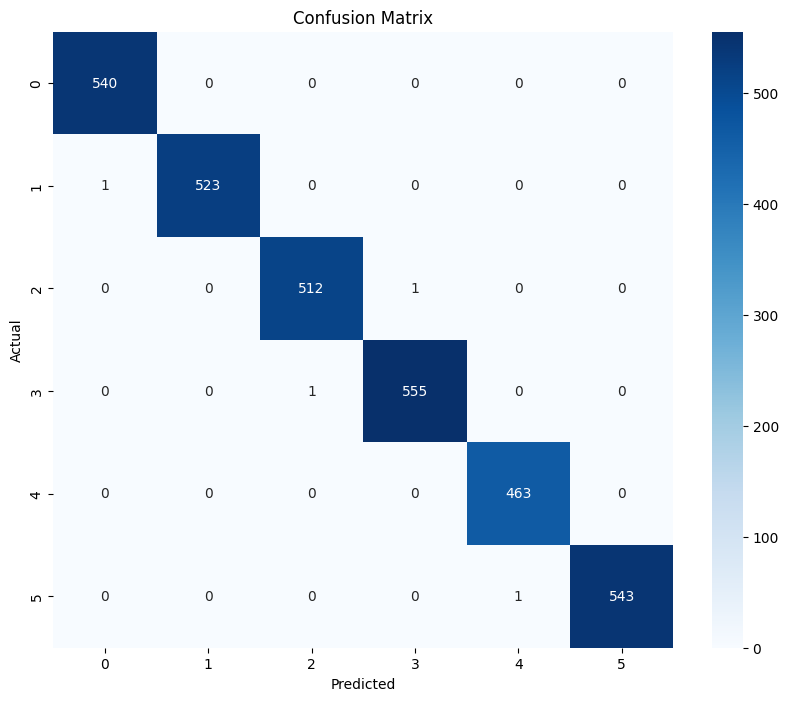

In [ ]:
# Evaluate the model

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy test: {accuracy:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [42]:
X_test_clean = X_test_clean[X_clean.columns]  # Align columns with the training set
y_pred_test = np.clip(np.round(model.predict(X_test_clean)), 0, 5)

# for id,y_pred in zip(ID_test,y_pred_test):
#     print(str(id)+","+str(int(y_pred)))

df_output = pd.DataFrame({'id': ID_test, 'price': y_pred_test})

# Convert y_pred to integers
df_output['price'] = df_output['price'].astype(int)

# Specify the file path
file_path = 'data/my_preds_with_reviews_name_and_des_redone.csv'

# Write the DataFrame to a CSV file
df_output.to_csv(file_path, index=False)

In [ ]:
# # Define the parameter dictionary for XGBClassifier
# params = {
#     'learning_rate': 0.1,
#     'n_estimators': 150,  # Equivalent to the number of boosting rounds
#     'max_depth': 9,
#     'reg_lambda': 0.1,     # L2 regularization parameter
# }

# # Initialize the model with the parameters
# model = XGBClassifier(**params, random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = model.predict(X_val)

# # Evaluate the model using accuracy
# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy on validation set:", accuracy)

# # Calculate RMSE between predicted and true quantile classes
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# import numpy as np

# # Define the base model
# model = xgb.XGBRegressor(
#     reg_lambda=1.0,
#     reg_alpha=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='reg:squarederror',
#     eval_metric='rmse',
#     random_state=1
# )

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'n_estimators': [100, 500, 1000]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available cores
#     verbose=2
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = np.sqrt(-grid_search.best_score_)  # Convert MSE to RMSE

# print("Best parameters:", best_params)
# print("Best RMSE:", best_score)

# # Use the best model for predictions
# best_model = grid_search.best_estimator_
# y_pred = np.clip(np.round(best_model.predict(X_val)), 0, 5)
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# import numpy as np

# # Define the base model
# model = xgb.XGBRegressor(
#     reg_lambda=1.0,
#     reg_alpha=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='reg:squarederror',
#     eval_metric='rmse',
#     random_state=1
# )

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'n_estimators': [100, 500, 1000]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available cores
#     verbose=2
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = np.sqrt(-grid_search.best_score_)  # Convert MSE to RMSE

# print("Best parameters:", best_params)
# print("Best RMSE:", best_score)

# # Use the best model for predictions
# best_model = grid_search.best_estimator_
# y_pred = np.clip(np.round(best_model.predict(X_val)), 0, 5)


In [ ]:
# # First XGBoost model
# params1 = {
#     'learning_rate': 0.01,
#     'max_depth': 9,
#     'min_child_weight': 3,
#     'reg_lambda': 1.0,
#     'reg_alpha': 0.1,
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'objective': 'reg:squarederror',
#     'eval_metric': ['rmse', 'mae'],
#     'tree_method': 'hist',
#     'device': 'cuda',
#     'random_state': 1
# }

# model1 = xgb.XGBRegressor(**params1)

# # Train the first model
# model1.fit(X_train, y_train)

# # Get predictions from the first model
# X_train_pred = model1.predict(X_train).reshape(-1, 1)
# X_val_pred = model1.predict(X_val).reshape(-1, 1)

# # Ensure amenities_df is a list of column names
# selected_columns = list(amenities_df.columns)  # Replace with actual column names if needed
# X_train2 = X_train[selected_columns]    
# X_val2 = X_val[selected_columns]    
# # Combine the predictions with extra training data
# X_train_combined = np.hstack((X_train2, X_train_pred))
# X_val_combined = np.hstack((X_val2, X_val_pred))


In [ ]:
# # Second XGBoost model
# params2 = {
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'min_child_weight': 75,
#     'reg_lambda': 0.8,
#     'reg_alpha': 0.2,
#     'n_estimators': 800,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'objective': 'reg:squarederror',
#     'eval_metric': ['rmse', 'mae'],
#     'random_state': 7
# }

# # Create the second XGBoost model without scaling
# model2 = xgb.XGBRegressor(**params2)

# # Train the second model
# model2.fit(X_train_combined, y_train)

# # Make predictions using the second model
# y_pred = np.clip(np.round(model2.predict(X_val_combined)), 0, 5)

# # Calculate accuracy and RMSE on validation set
# accuracy = accuracy_score(y_val, y_pred)
# print(f"Accuracy on validation set: {accuracy:.4f}")

# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Root Mean Squared Error on validation set: {rmse:.4f}")

# # Predictions on training set
# y_pred_train = np.clip(np.round(model2.predict(X_train_combined)), 0, 5)

# # Calculate accuracy and RMSE on training set
# train_accuracy = accuracy_score(y_train, y_pred_train)
# print(f"Accuracy on training set: {train_accuracy:.4f}")

# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print(f"Root Mean Squared Error on training set: {train_rmse:.4f}")

# # Classification report on validation set
# print("\nClassification Report on validation set:")
# print(classification_report(y_val, y_pred))

# # Feature importance (sorted) for the second model
# importance = model2.get_booster().get_score(importance_type='weight')
# sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
# print("\nTop 10 Important Features:")
# for feature, score in sorted_importance[:10]:
#     print(f"{feature}: {score}")

In [ ]:
# # Get predictions from the first model
# X_test_pred = model1.predict(X_test_clean).reshape(-1, 1)
# # Ensure amenities_df is a list of column names
# selected_columns = list(amenities_df.columns)  # Replace with actual column names if needed
# X_test2 = X_test_clean[selected_columns]    
# # Combine the predictions with extra training data
# X_train_combined = np.hstack((X_test2, X_test_pred))
# y_pred_test = np.clip(np.round(model2.predict(X_train_combined)), 0, 5)

# # for id,y_pred in zip(ID_test,y_pred_test):
# #     print(str(id)+","+str(int(y_pred)))

# df_output = pd.DataFrame({'id': ID_test, 'price': y_pred_test})

# # Convert y_pred to integers
# df_output['price'] = df_output['price'].astype(int)

# # Specify the file path
# file_path = 'data/my_preds2.csv'

# # Write the DataFrame to a CSV file
# df_output.to_csv(file_path, index=False)